In [1]:
import warnings
warnings.filterwarnings("ignore")
import os.path
import numpy as np
import pandas as pd
from scipy import stats
import tensorflow as tf
from datetime import datetime
from sklearn.preprocessing import scale
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, balanced_accuracy_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, LeaveOneOut

import seaborn as sns
import matplotlib.pyplot as plt
from aggmap import AggMap, AggMapNet, show, loadmap, AggMapNet_DP

In [2]:
#GPU selection
gpu_id = "0"
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_id
physical_gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)

In [3]:
#Self-definition
file = "Bortezomib"
drug = "PS341" #PS341/Dex
data_split = "NR-R_response" #PD-R_response/NR-R_response

clu_channels = 5
cv = 5
ran_seed = 0

#Data Input
data_T = pd.read_csv("./0_datasets/{}_log2expression-response+trial+drug.csv".format(file), header = 0, index_col = 0)
dataX = data_T.drop(columns = ["PD-R_response","NR-R_response","trial","drug"])

data_T = data_T[pd.notnull(data_T[data_split])]
train_xy = data_T.loc[[i in [25, 40] for i in data_T["trial"]]]
test_xy = data_T.loc[data_T["trial"] == 39].loc[data_T["drug"] == drug]

trainX = train_xy.drop(columns = ["PD-R_response","NR-R_response","trial","drug"])
testX = test_xy.drop(columns = ["PD-R_response","NR-R_response","trial","drug"])
trainY = train_xy[data_split]
testY = test_xy[data_split]

In [4]:
trainX

A1CF       A2M    A4GALT     A4GNT      AAAS      AACS  \
GSM246523  8.030943  4.846017  5.454771  4.565975  7.177459  7.355571   
GSM246524  7.235622  5.055330  5.813396  5.915160  6.879081  8.252140   
GSM246525  6.996728  4.949712  5.083886  5.434455  7.189746  7.627972   
GSM246526  6.919269  4.755523  5.309151  6.537057  6.390453  8.072942   
GSM246527  7.877462  6.257013  6.884012  7.242383  6.655151  7.402876   
...             ...       ...       ...       ...       ...       ...   
GSM246670  6.955324  6.393986  5.124403  5.590689  7.129633  7.615402   
GSM246671  6.981442  5.839771  4.384955  5.807481  6.660253  7.201546   
GSM246672  7.569810  5.451791  6.240095  6.776920  6.779352  7.333531   
GSM246673  7.083575  5.693844  5.797363  6.669580  7.034370  7.012881   
GSM246675  6.833308  5.583525  6.124818  6.382043  7.163388  6.929767   

              AADAC     AAGAB      AAK1     AAMDC  ...    ZSWIM1    ZSWIM8  \
GSM246523  3.975318  6.776792  7.240334  6.095186  ...  6.181637  7.024723   
GSM246524  3.593473  6.396298  6.526406  5.299362  ...  6.316844  7.487334   
GSM246525  2.788876  6.568766  5.265558  5.428113  ...  5.893292  6.887492   
GSM246526  3.181718  6.640696  6.233993  5.659564  ...  5.814794  7.963797   
GSM246527  5.534930  5.874436  6.456462  5.577521  ...  6.130181  7.120616   
...             ...       ...       ...       ...  ...       ...       ...   
GSM246670  2.301760  6.393751  5.741771  5.386615  ...  5.788367  6.647990   
GSM246671  3.148594  6.423065  5.820280  5.164029  ...  5.895441  6.310712   
GSM246672  4.076619  5.959568  6.671434  6.104774  ...  6.525432  6.566181   
GSM246673  4.717951  6.201491  5.979126  5.832252  ...  6.339333  6.312520   
GSM246675  3.872395  6.868613  6.271607  6.573626  ...  6.586780  7.091504   

               ZW10    ZWILCH     ZWINT      ZXDB      ZXDC       ZYX  \
GSM246523  7.375926  5.863507  8.361926  2.811241  7.059377  7.432755   
GSM246524  7.507327  6.762149  9.052291  4.089879  7.324991  7.278496   
GSM246525  7.482146  6.087365  8.923111  4.140901  6.164163  6.276348   
GSM246526  7.178167  5.863854  7.249521  4.855447  6.983621  7.506185   
GSM246527  7.819987  6.735441  8.130674  4.005625  4.301185  5.714689   
...             ...       ...       ...       ...       ...       ...   
GSM246670  6.899381  6.316274  7.911512  4.461404  6.215809  7.032217   
GSM246671  7.514627  6.157428  8.218248  2.759914  5.025237  6.683668   
GSM246672  7.899290  6.140147  8.512330  5.259864  4.309162  7.478495   
GSM246673  7.655366  4.527302  5.636396  4.322505  3.641477  5.639173   
GSM246675  7.534038  6.783928  7.982560  4.778056  6.096000  6.891054   

              ZZEF1      ZZZ3  
GSM246523  7.234013  6.454664  
GSM246524  6.103515  7.284496  
GSM246525  6.901812  7.699149  
GSM246526  6.139795  6.893411  
GSM246527  6.491329  6.050604  
...             ...       ...  
GSM246670  5.676010  7.317548  
GSM246671  5.849300  7.495407  
GSM246672  5.950672  7.032652  
GSM246673  6.806076  7.058641  
GSM246675  6.537900  6.939509  

[91 rows x 12548 columns]

In [5]:
phe_list = []
ref_phe = pd.read_csv("./0_datasets/Bortezomib_PD-R_phenotype.csv", header = 0, index_col = 0)
for i in trainX.index:
    phe_list.append(ref_phe.loc[i, "characteristics_ch1.7"][-2:])
ref_phe

characteristics_ch1.7
GSM246523     PGx_Response = NC
GSM246524     PGx_Response = NC
GSM246525     PGx_Response = PR
GSM246526     PGx_Response = NC
GSM246527     PGx_Response = PR
...                         ...
GSM246773     PGx_Response = NC
GSM246774     PGx_Response = PR
GSM246775     PGx_Response = NC
GSM246776     PGx_Response = PD
GSM246777     PGx_Response = PR

[255 rows x 1 columns]

In [6]:
#AggMap transformation
if os.path.isfile("./1_aggmap/{}_DR_channels({})_{}-cv_{}.mp".format(file,clu_channels,cv,ran_seed)):
    mp = loadmap("./1_aggmap/{}_DR_channels({})_{}-cv_{}.mp".format(file,clu_channels,cv,ran_seed))
else:
    if os.path.isfile("./1_aggmap/{}_DR_channels({})_{}-cv_{}.mp".format(file,5,cv,ran_seed)):
        mp = loadmap("./1_aggmap/{}_DR_channels({})_{}-cv_{}.mp".format(file,5,cv,ran_seed))
    else:
        mp = AggMap(dataX, metric = "correlation")
    mp.fit(cluster_channels = clu_channels)
    mp.save("./1_aggmap/{}_DR_channels({})_{}-cv_{}.mp".format(file,clu_channels,cv,ran_seed))

trainX_mp = mp.batch_transform(trainX.values)
testX_mp = mp.batch_transform(testX.values)
trainY_binary = tf.keras.utils.to_categorical(trainY.values,2)
testY_binary = tf.keras.utils.to_categorical(testY.values,2)

100%|##########| 65/65 [00:12<00:00,  5.39it/s]


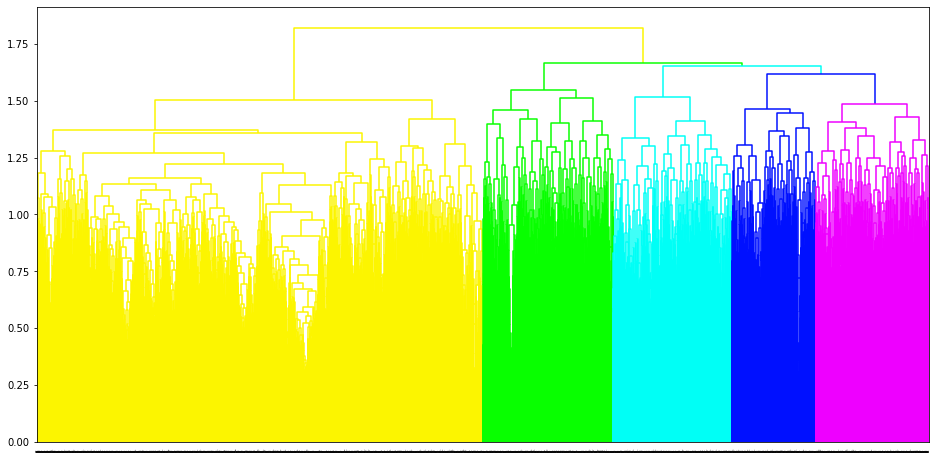

In [7]:
#Feature tree
fig_tree = mp.plot_tree(add_leaf_labels = False, leaf_font_size = 1)
fig_tree.savefig("./6_figure/{}_cluster{}_tree.jpg".format(file, clu_channels), bbox_inches='tight', dpi=300)

In [50]:
#2D grid represention
mp.plot_grid(htmlpath='./6_figure/', htmlname="{}_channels({})".format(file,clu_channels))

2022-12-05 15:29:51,328 - INFO - [bidd-aggmap] - generate file: ./6_figure/Bortezomib+PS341+NR-R_response_channels(5)_feature points_12548_correlation_umap_mp
2022-12-05 15:29:51,526 - INFO - [bidd-aggmap] - save html file to ./6_figure/Bortezomib+PS341+NR-R_response_channels(5)_feature points_12548_correlation_umap_mp


In [9]:
#2D scatter distribution
mp.plot_scatter(htmlpath='./6_figure/', htmlname="{}_channels({})".format(file,clu_channels))

2022-11-29 15:20:39,061 - INFO - [bidd-aggmap] - generate file: ./6_figure/Bortezomib_channels(5)_feature points_12548_correlation_umap_scatter
2022-11-29 15:20:39,269 - INFO - [bidd-aggmap] - save html file to ./6_figure/Bortezomib_channels(5)_feature points_12548_correlation_umap_scatter


In [11]:
#Differentially Expressed Levels
fp_frame = pd.DataFrame()
fs_method = "MannW"

trainX["Sample_Label"] = trainY
gene_frame_1 = trainX[trainX["Sample_Label"]==1].drop(columns = "Sample_Label")
gene_frame_0 = trainX[trainX["Sample_Label"]==0].drop(columns = "Sample_Label")

if fs_method == "MannW":
    for i in gene_frame_1.columns:
        sg_1 = gene_frame_1[i]
        sg_0 = gene_frame_0[i]
        MU, pvalue = stats.mannwhitneyu(sg_1,sg_0,alternative='two-sided')
        if np.mean(sg_1.values) > np.mean(sg_0.values):
            DE_status = "+"
        else:
            DE_status = "-"
        fp_frame[i] = [MU, pvalue, DE_status]
fp_frame.index = ["MU","P-Value","Up-Regulation"]

fp_frame.T.sort_values("P-Value")

MU      P-Value Up-Regulation
SNTB2    1654  9.12354e-07             +
ERH       462  5.50633e-06             -
GSDMB    1596  8.61693e-06             +
COX7C     490  1.54449e-05             -
TFF3     1567  2.45332e-05             +
...       ...          ...           ...
CERS6    1036     0.996833             -
CLDN15   1036     0.996833             +
PKD2L2   1034     0.996833             -
ITGB3BP  1035     0.996833             -
EML4     1036     0.996833             -

[12548 rows x 3 columns]

In [12]:
def imshow(x_arr,  ax, mode = 'dark',  color_list = ['#1300ff','#ff0c00','#25ff00', '#d000ff','#e2ff00', '#00fff6', \
                                                     '#ff8800', '#fccde5','#178b66', '#8a0075'], x_max = 255, vmin = -1, vmax = 1):
    
    
    assert x_arr.ndim == 3, 'input must be 3d array!'
    w, h, c = x_arr.shape
    assert len(color_list) >= c, 'length of the color list should equal or larger than channel numbers'
    
    x = x_arr.copy()
    x[x == 0] = 'nan'

    xxx = x_arr.sum(axis=-1)
    xxx[xxx != 0] = 'nan'

    if mode == 'dark':
        cmaps = [sns.dark_palette(color, n_colors =  50, reverse=False) for color in color_list]

    else:
        cmaps = [sns.light_palette(color, n_colors =  50, reverse=False) for color in color_list]
        
    for i in range(c):
        data = x[:,:,i]/x_max
        sns.heatmap(data, cmap = cmaps[i], vmin = vmin, vmax = vmax, \
                    yticklabels=False, xticklabels=False, cbar=False, ax=ax) # linewidths=0.005, linecolor = '0.9'

In [13]:
file = f"{file}+{drug}+{data_split}"

In [14]:
phe_list

['NC',
 'NC',
 'PR',
 'NC',
 'PR',
 'MR',
 'NC',
 'PD',
 'NC',
 'PD',
 'PR',
 'MR',
 'PR',
 'PR',
 'PR',
 'PD',
 'PR',
 'PR',
 'CR',
 'MR',
 'PR',
 'PR',
 'PR',
 'PR',
 'PR',
 'MR',
 'PR',
 'PD',
 'PR',
 'NC',
 'NC',
 'PR',
 'PD',
 'PR',
 'PR',
 'NC',
 'PR',
 'NC',
 'PD',
 'PR',
 'PR',
 'PD',
 'PD',
 'PD',
 'PR',
 'MR',
 'PD',
 'NC',
 'NC',
 'PD',
 'MR',
 'PR',
 'NC',
 'NC',
 'NC',
 'PD',
 'NC',
 'PR',
 'MR',
 'NC',
 'PR',
 'PR',
 'PR',
 'PR',
 'PR',
 'NC',
 'NC',
 'PD',
 'PD',
 'PD',
 'PD',
 'PD',
 'PD',
 'NC',
 'PD',
 'NC',
 'NC',
 'NC',
 'NC',
 'PR',
 'PR',
 'PR',
 'PR',
 'CR',
 'MR',
 'MR',
 'CR',
 'PD',
 'PD',
 'NC',
 'PD']

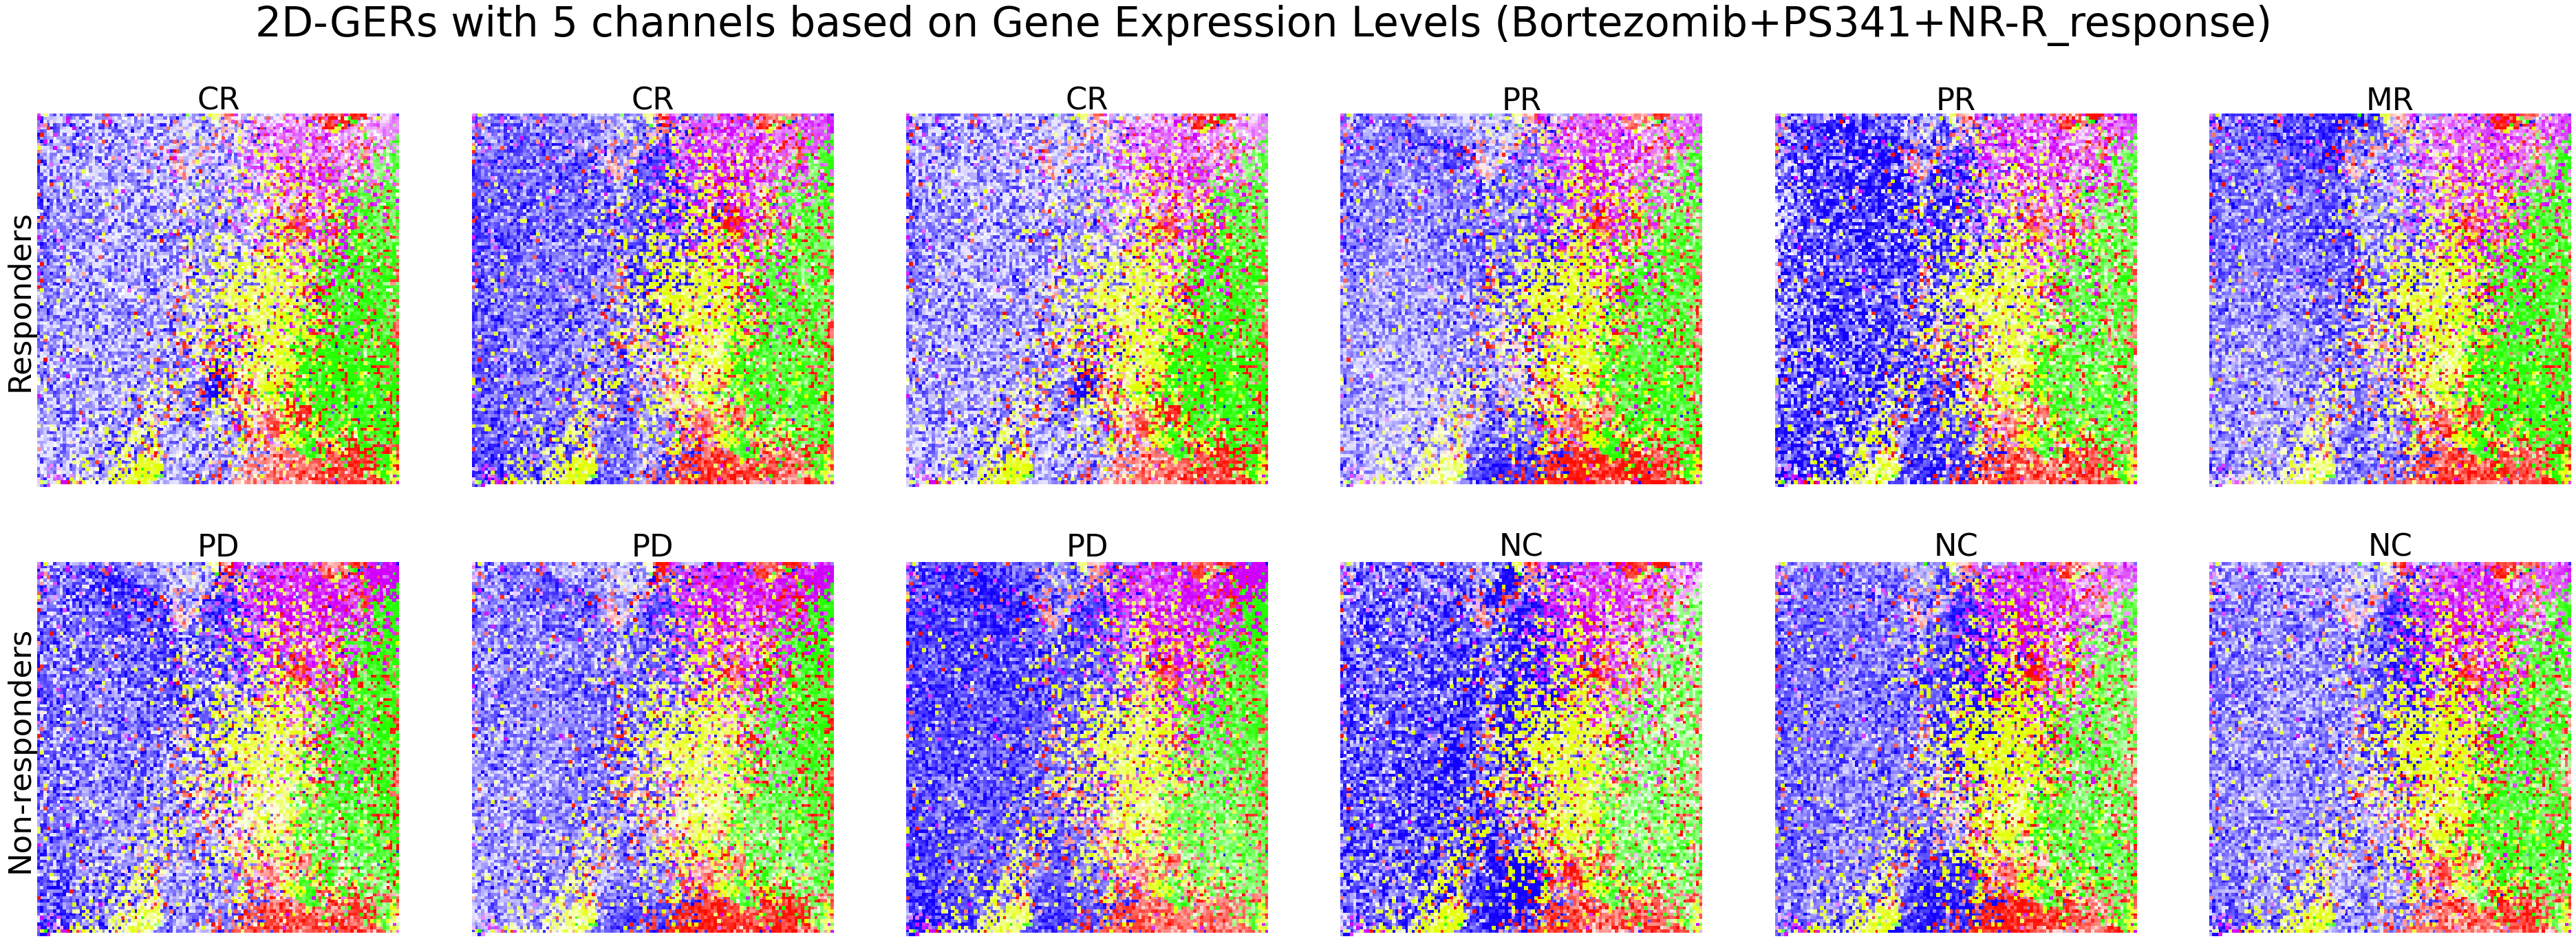

In [15]:
#2D-GERs output
#figure_mp = new_array.copy()
figure_mp = trainX_mp.copy()
figure_y = trainY.copy()
phe_list = phe_list

fv_max = np.percentile(figure_mp.sum(axis = -1), 90)
fv_min = np.percentile(figure_mp.sum(axis = -1), 5)

c_list = ['#1300ff', '#ff0c00', '#25ff00', '#d000ff', '#e2ff00', '#00fff6', '#ff8800', '#fccde5', '#178b66', '#8a0075', \
         '#ff99cc', '#00ccff', '#ff6600', '#339966', '#ccccff', '#008000', "#00ffff", '#00ff00', '#800000', '#cc99ff', \
         '#e1ffff', '#00ced1', '#808000', '#ffa07a', '#f08080', '#ffe4c4', '#ffe4e1', '#ffebcd', '#ffdab9', '#daa520']

ord_mp = np.argsort(figure_y.values)
trvn_list0 = [-5, 18, -5, 2, 4, 5]
trvn_list1 = [-1, 7, 9, 0, 1, 3]

fig, axes = plt.subplots(nrows=2, ncols=len(trvn_list0), figsize=(11*len(trvn_list0), 22), sharex = True, sharey = True)

for n,ax in zip(trvn_list0,axes[0]):
    imshow(figure_mp[n], ax, mode="white", color_list = c_list, x_max = 1, vmin = fv_min, vmax = fv_max) #color_list = ["black"]*5
    ax.set_title("{}".format(phe_list[n]),fontsize=45)

for n,ax in zip(trvn_list1,axes[1]):
    imshow(figure_mp[n], ax, mode="white", color_list = c_list, x_max = 1, vmin = fv_min, vmax = fv_max) #color_list = ["black"]*5
    ax.set_title("{}".format(phe_list[n]),fontsize=45)

fig.suptitle("2D-GERs with {} channels based on Gene Expression Levels ({})".format(clu_channels, file), fontsize=60)
axes[0,0].set_ylabel("Responders",fontsize=45)
axes[1,0].set_ylabel("Non-responders",fontsize=45)

fig.show()
fig.savefig("./6_figure/{}_final-channels({})_sample.jpg".format(file, clu_channels))

In [16]:
mp.fmap_shape

(113, 112)

In [19]:
#Important Genes with differentially expressed level
gene_imp = pd.read_csv("./5_feature_importance/Bortezomib_NR-R_response_simp-importance_channels(5)_0.csv", index_col = 0, header = 0)
gene_imp_pv = pd.concat([gene_imp, fp_frame.T[["P-Value","Up-Regulation"]]], axis = 1)
gene_imp_pv.sort_values("simply_importance_class_1", ascending = False)[:30]

x    y    Subtypes   colors  simply_importance_class_0  \
MRPL24       98   98  cluster_02  #08ff00                  11.614176   
DUSP11       99   97  cluster_03  #00fff6                  11.249470   
TMEM185B    103   96  cluster_03  #00fff6                   9.127264   
DCLRE1A     102   97  cluster_03  #00fff6                   8.242004   
CTNNBL1     101   99  cluster_03  #00fff6                   7.886166   
ANGEL1      108   13  cluster_03  #00fff6                   7.688965   
ARMC6       100    9  cluster_02  #08ff00                   7.555269   
TIMM9       104    6  cluster_04  #0010ff                   7.179891   
ELP5        106   95  cluster_03  #00fff6                   6.710780   
TRIP6       105    6  cluster_02  #08ff00                   6.506255   
CCNI        102   93  cluster_03  #00fff6                   6.288409   
IGBP1       105    3  cluster_04  #0010ff                   6.168783   
EIF3L       110    9  cluster_04  #0010ff                   6.161677   
TMEM14A     100   94  cluster_03  #00fff6                   6.155962   
MAPKAPK5    110   96  cluster_02  #08ff00                   6.092685   
KRAS         99   96  cluster_03  #00fff6                   6.048611   
H2AFZ       102  101  cluster_02  #08ff00                   5.964342   
NDUFB1      106   19  cluster_03  #00fff6                   5.958987   
RPL11       110   18  cluster_03  #00fff6                   5.928780   
ZNF432       65   33  cluster_04  #0010ff                   5.915155   
ZNF16       100    4  cluster_05  #ee00ff                   5.818201   
PLP2         88   93  cluster_03  #00fff6                   5.804174   
DPH5        105    9  cluster_04  #0010ff                   5.774592   
GPN1        100   88  cluster_03  #00fff6                   5.771136   
GADD45GIP1  107   15  cluster_03  #00fff6                   5.747901   
LAMTOR3     104  100  cluster_02  #08ff00                   5.713682   
MICAL1       63   27  cluster_04  #0010ff                   5.694671   
NDUFB7      104    9  cluster_03  #00fff6                   5.666452   
LAMTOR2      99  101  cluster_02  #08ff00                   5.629742   
RPS21       106    9  cluster_04  #0010ff                   5.512546   

            simply_importance_class_1      P-Value Up-Regulation  
MRPL24                      11.614211     0.037185             -  
DUSP11                      11.249509     0.268142             -  
TMEM185B                     9.127234     0.338805             -  
DCLRE1A                      8.241980     0.248099             -  
CTNNBL1                      7.886223     0.688516             -  
ANGEL1                       7.689045   0.00178649             -  
ARMC6                        7.555265     0.759899             -  
TIMM9                        7.179849  0.000499888             -  
ELP5                         6.710734     0.653794             +  
TRIP6                        6.506131     0.338805             -  
CCNI                         6.288364     0.371843             -  
IGBP1                        6.168725   0.00221262             -  
EIF3L                        6.161748  9.87703e-05             -  
TMEM14A                      6.155959     0.796418             -  
MAPKAPK5                     6.092704     0.482359             -  
KRAS                         6.048609     0.389087             -  
H2AFZ                        5.964351     0.024422             -  
NDUFB1                       5.959104  3.02703e-05             -  
RPL11                        5.928828  0.000160314             -  
ZNF432                       5.915216     0.614217             +  
ZNF16                        5.818215    0.0513216             -  
PLP2                         5.804212     0.575732             -  
DPH5                         5.774585    0.0626788             -  
GPN1                         5.771162    0.0760392             -  
GADD45GIP1                   5.747907     0.564949             -  
LAMTOR3                      5.713733  

In [35]:
ncols = gene_imp_pv.sort_values("simply_importance_class_1", ascending = False)[:30].index
data = pd.concat([trainX.loc[:,cols],trainY],axis=1)
data = pd.melt(data, id_vars = [data_split], var_name = "Gene Symbol", value_name = "log2 Expression Level")
data["NR-R_response"].replace(0,"Non-responder",inplace=True)
data["NR-R_response"].replace(1,"Responder",inplace=True)

y  = 'log2 Expression Level'
hue = data_split
x = "Gene Symbol"

box_pairs = [((col, "Non-responder"), (col, "Responder")) for col in ncols]
order = ncols
#****P < 0.0001 by two-tailed Wilcoxon rank sum test.

In [36]:
data

NR-R_response Gene Symbol  log2 Expression Level
0     Non-responder      MRPL24               9.273737
1     Non-responder      MRPL24               8.197743
2         Responder      MRPL24               9.205407
3     Non-responder      MRPL24               9.537880
4         Responder      MRPL24               9.452651
...             ...         ...                    ...
2725      Responder       RPS21              10.777608
2726  Non-responder       RPS21              11.067123
2727  Non-responder       RPS21              12.322210
2728  Non-responder       RPS21              11.741259
2729  Non-responder       RPS21              13.060254

[2730 rows x 3 columns]

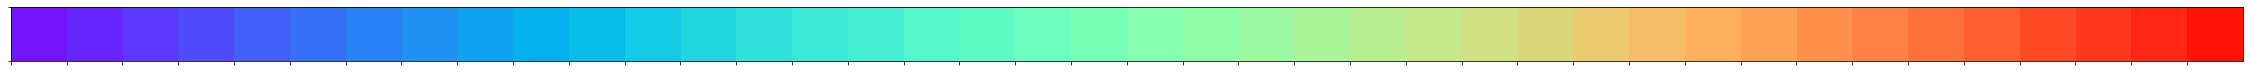

In [37]:
color = sns.color_palette('rainbow', len(f) + 10).as_hex()
sns.palplot(color)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

TRIP6_Non-responder v.s. TRIP6_Responder: Mann-Whitney-Wilcoxon test two-sided, P_val=3.388e-01 U_stat=1.156e+03
CCNI_Non-responder v.s. CCNI_Responder: Mann-Whitney-Wilcoxon test two-sided, P_val=3.718e-01 U_stat=1.148e+03
IGBP1_Non-responder v.s. IGBP1_Responder: Mann-Whitney-Wilcoxon test two-sided, P_val=2.213e-03 U_stat=1.421e+03
EIF3L_Non-responder v.s. EIF3L_Responder: Mann-Whitney-Wilcoxon test two-sided, P_val=9.877e-05 U_stat=1.526e+03
TMEM14A_Non-responder v.s. TMEM14A_Responder: Mann-Whitney-Wilcoxon test two-sided, P_val=7.964e-01 U_stat=1.068e+03
MAPKAPK5_Non-responder v.s. MAPKAPK5_Responder: Mann-Whitney-Wilcoxon test two-sided, P_val=4.824e-01 U_stat=1.124e+03
KRAS_Non-responder v.s. KRAS_Responder: Mann-Whitney-Wilcoxon test two-sided, P_val=3.891e-01 U_stat=1.144e+03
H2AFZ_Non-responder v.s. H2AFZ_Responde

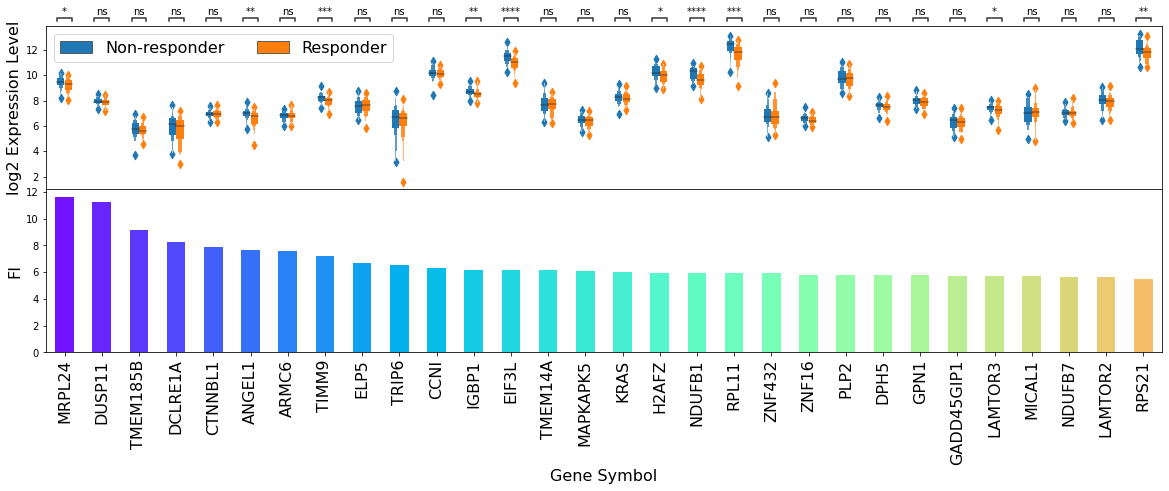

In [46]:
f = gene_imp_pv.loc[ncols]
fig, ax  = plt.subplots(2, 1, figsize=(20, 6), sharex=True)

ax, ax2 = ax
# g = sns.swarmplot(x=x, y=y, hue = hue, data=data, color= ".2", order = order, ax= ax, size = 6,
#                      split=True,   linewidth=1, edgecolor='gray') #palette="Set2",palette = [".8", ".8"] jitter=True,
    
flierprops = dict(marker='o',markerfacecolor='0.75', markersize=5, linestyle='none')
    
sns.boxenplot(data = data,y=y, x = x, hue = hue,  ax = ax, width = 0.4, saturation = 1,
              #k_depth = "proportion" , scale = 'linear', 
              order = order) # palette="Set1_r", , flierprops = flierprops

ax, test_results = add_stat_annotation(ax, data=data, x=x, y=y, hue = hue, test='Mann-Whitney', 
                                       box_pairs=box_pairs, comparisons_correction=None,
                                       text_format='star', loc='outside', verbose=2)
ax.set_ylabel(y,fontsize=16)

#ax.set_ylim(-10, -2)


ax.legend(loc='upper left',fancybox=True,  ncol=2, fontsize=16)

p = f["simply_importance_class_1"].tolist()
p = [{i: j} for i, j in enumerate(p)]
p = pd.DataFrame(p, index = f.index)
p.plot(kind ='bar',stacked=True, ax = ax2, color = color, legend=False, )

ax2.set_ylabel("FI", fontsize=16)
ax2.set_xlabel(x, fontsize=16)
ax2.set_xticklabels(labels = f.index.tolist(), rotation=90, ha='center', fontsize = 16)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.000)
plt.savefig('./6_figure/statistic_test.jpg', dpi=400, bbox_inches='tight')